In [1]:
import os
import numpy as np
import pandas as pd
import random
import cv2
import seaborn as sns
from PIL import Image
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
import argparse
# import imutils
%matplotlib inline
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from keras.layers import Dense, GlobalAveragePooling2D,Input,Flatten, Dropout,BatchNormalization
from keras.models import Model, Sequential
from keras import backend as K
from keras.applications.densenet import DenseNet121
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
import tensorflow as tf


# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


In [2]:
train_dir_path ="/kaggle/input/chest-xray-pneumonia/chest_xray/train"
test_dir_path= "/kaggle/input/chest-xray-pneumonia/chest_xray/test"

In [3]:
# Get few samples for both the classes
normal_cases_dir = os.path.join(train_dir_path,'NORMAL')
pneumonia_cases_dir = os.path.join(train_dir_path,'PNEUMONIA')

# Get the list of all the images
normal_cases = glob(normal_cases_dir + '/*.jpeg') 
pneumonia_cases = glob(pneumonia_cases_dir + '/*.jpeg')


In [4]:
print(f"Total number of image for normal cases : {len(normal_cases)}\n\
Total number of image for pneumonia cases : {len(pneumonia_cases)}")

Total number of image for normal cases : 1341
Total number of image for pneumonia cases : 3875


In [5]:
samples=[]
for i in range(5):
    samples.append(normal_cases[i])
for i in range(5):
    samples.append(pneumonia_cases[i])

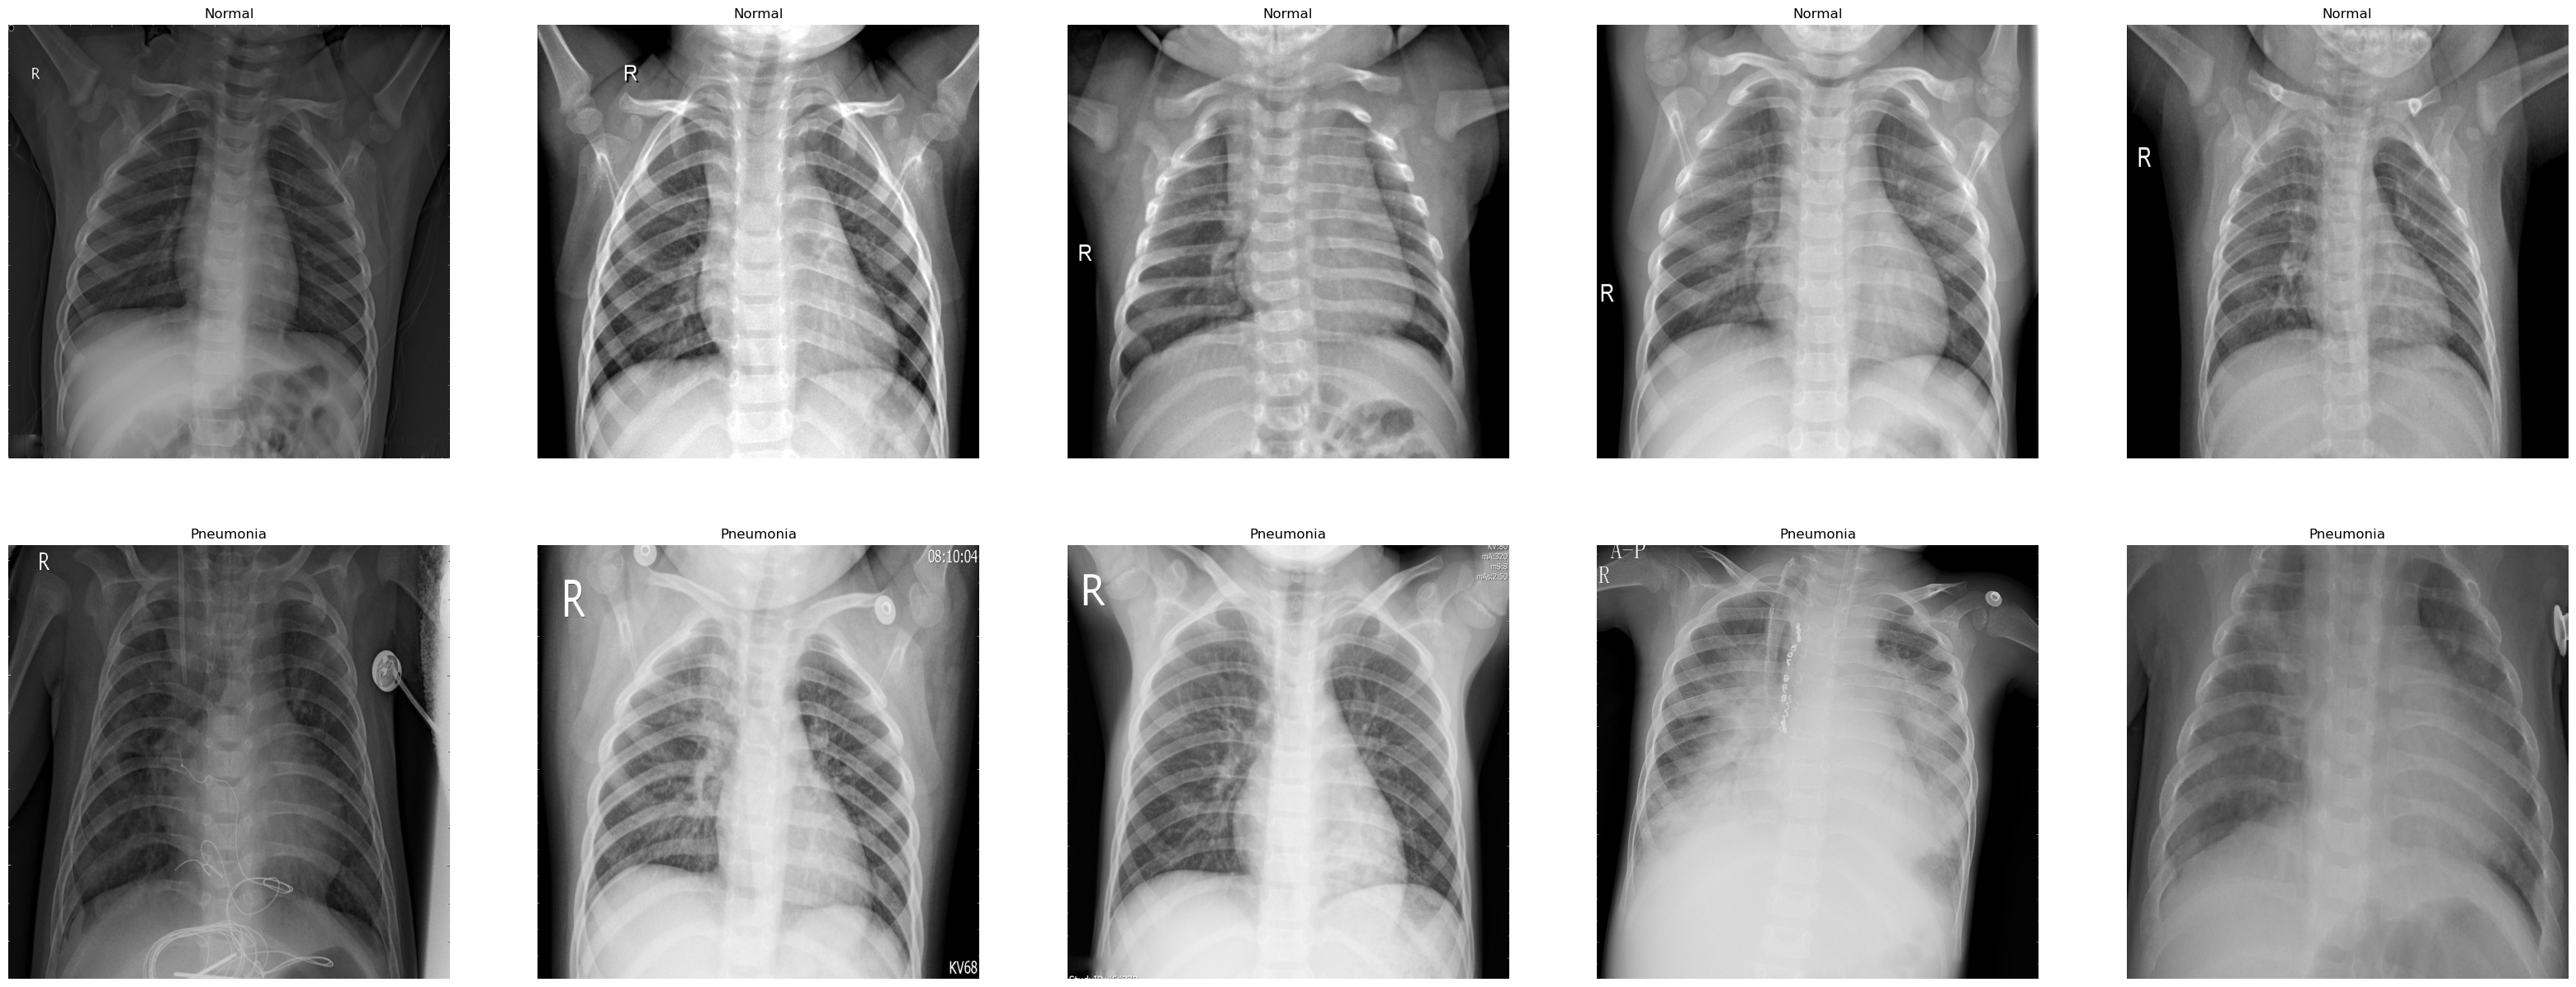

In [6]:

# Plot the data 
f, ax = plt.subplots(2,5, figsize=(40,15))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Normal")
    else:
        ax[i//5, i%5].set_title("Pneumonia")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

### Image Data Augmentation
ImageDataGenerator is used to dynamically augment the images while passing the data in batches during training.



In [7]:
# Data generation objects
train_datagen = ImageDataGenerator(zoom_range=0.1,     
                                   horizontal_flip = True,
                                   fill_mode = 'constant',
                                   validation_split=0.1,
                                   preprocessing_function = preprocess_input)

test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

In [8]:
image_size = 224
batch_size = 32

# This is fed to the network in the specified batch sizes and image dimensions
train_gen = train_datagen.flow_from_directory(train_dir_path, 
                                              target_size=(image_size, image_size), 
                                              batch_size=batch_size, 
                                              class_mode='binary', 
                                              shuffle=True,
                                              subset='training')

val_gen = train_datagen.flow_from_directory(train_dir_path, # same directory as training data
                                                  target_size=(image_size, image_size),
                                                  batch_size=batch_size,
                                                  shuffle = True,
                                                  class_mode='binary',
                                                  subset='validation')

test_gen = test_datagen.flow_from_directory(test_dir_path, 
                                                target_size=(image_size, image_size), 
                                                batch_size=batch_size, 
                                                class_mode='binary', 
                                                shuffle=True)

Found 4695 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### Handling Class Imbalance using Weighted Loss Function
The dataset is imbalanced as the number of normal images is quite high than the number of  pneumonia images. Class imbalance represents an important problem for intelligent classification algorithms.

The goal is to identify normal/pneumonia ,but we don't have very many of those pneumonia samples and so we would want to have the classifier heavily weight the few examples that are available.This will cause the model to "pay more attention" to examples from an under-represented class.

In keras,this can be done by passing Keras weights for each class through a parameter class weight in model fit method.

In [9]:
train_labels=[]


for img_path in normal_cases:
    train_labels.append(0)

for img_path in pneumonia_cases:
    train_labels.append(1)

#convert label list to numpy array
train_labels = np.array(train_labels)

#Compute class weights for each class
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(train_labels),y=train_labels)
print(class_weights)

[1.9448173  0.67303226]


### Transfer Learning
Transfer learning is a machine learning method where a model developed for a task is reused as the starting point for a model on a second task.
It is a popular approach in deep learning where pre-trained models are used as the starting point on computer vision and natural language processing tasks given the vast compute and time resources required to develop neural network models on these problems and from the huge jumps in skill that they provide on related problems.

In [10]:
# create the base pre-trained model
base_model = DenseNet121(weights='imagenet',include_top=False)
x = base_model.output

# add a global spatial average pooling layer
x= GlobalAveragePooling2D()(x)

# dropout layer
x= Dropout(0.2)(x)

# add a logistic layers
prediction = Dense(1, activation="sigmoid")(x)

model= Model(inputs=base_model.inputs, outputs=prediction)

29084464/29084464 [==============================] - 0s 0us/step


## Freeze the convolutional base
It is important to freeze the convolutional base before you compile and train the model. In Keras, freezing *(by setting layer.trainable = False)* prevents the weights in each layer from being updated during training. 

In [11]:
 # don't train existing weights
for layer in base_model.layers:
    layer.trainable=False

In [12]:
# check the model summary and trainable parameters
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1/conv (Conv2D)            (None, None, None,   9408        ['zero_padding2d[0][0]']         
                                64)                                                           

Optimizer: We use Adam optimizer and we initialise the learning rate with 0.0001
Loss: We use binary cross-entropy since it is a binary classification task.

ReduceLRonPlateau : Reduce learning rate when a metric has stopped improving. Models often benefit from reducing the learning rate once learning stagnates.

EarlyStopping: Stop training when a monitored metric has stopped improving. Assuming the goal of a training is to minimize the loss. With this, the metric to be monitored would be 'loss', and mode would be 'min'. Once it's found no longer decreasing, the training terminates.

ModelCheckpoint: Callback to save the Keras model or model weights at some frequency. It is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.

In [13]:
#Follow ChexNeXt Paper
base_learning_rate = 0.0001

# compile model
model.compile(optimizer=Adam(learning_rate= base_learning_rate),loss="binary_crossentropy",metrics=['accuracy'])

We first train the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

We save the best model in the process based on validation loss.

The learning rate is reduced by a factor of 10 when the validation loss does not improve for an epoch.

Early stopping is used to stop thr training in between if validation loss does not improve.

In [14]:
#epochs
initial_epochs = 20

# Callbacks
#Save best model
ckpt_filename= "/kaggle/working/dn121_class_weights_pretrained.hdf5"
checkpoint = ModelCheckpoint(filepath=ckpt_filename, save_best_only=True, save_weights_only=True, verbose = 1)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, mode='min', verbose = 1)

In [15]:
# fitting the model
history= model.fit(train_gen, 
                  epochs=initial_epochs,
                  validation_data= val_gen,
                  callbacks=[checkpoint, early_stop, lr_reduce], 
                  class_weight = {0: class_weights[0], 1: class_weights[1]}
                  )

Epoch 1/20
147/147 [==============================] - ETA: 0s - loss: 1.8479 - accuracy: 0.5199
Epoch 1: val_loss improved from inf to 1.03090, saving model to /kaggle/working/dn121_class_weights_pretrained.hdf5
147/147 [==============================] - 167s 1s/step - loss: 1.8479 - accuracy: 0.5199 - val_loss: 1.0309 - val_accuracy: 0.5010 - lr: 1.0000e-04
Epoch 2/20
147/147 [==============================] - ETA: 0s - loss: 1.5361 - accuracy: 0.5459
Epoch 2: val_loss improved from 1.03090 to 0.73104, saving model to /kaggle/working/dn121_class_weights_pretrained.hdf5
147/147 [==============================] - 123s 835ms/step - loss: 1.5361 - accuracy: 0.5459 - val_loss: 0.7310 - val_accuracy: 0.6430 - lr: 1.0000e-04
Epoch 3/20
147/147 [==============================] - ETA: 0s - loss: 1.4163 - accuracy: 0.5557
Epoch 3: val_loss improved from 0.73104 to 0.71171, saving model to /kaggle/working/dn121_class_weights_pretrained.hdf5
147/147 [==============================] - 122s 831ms/s

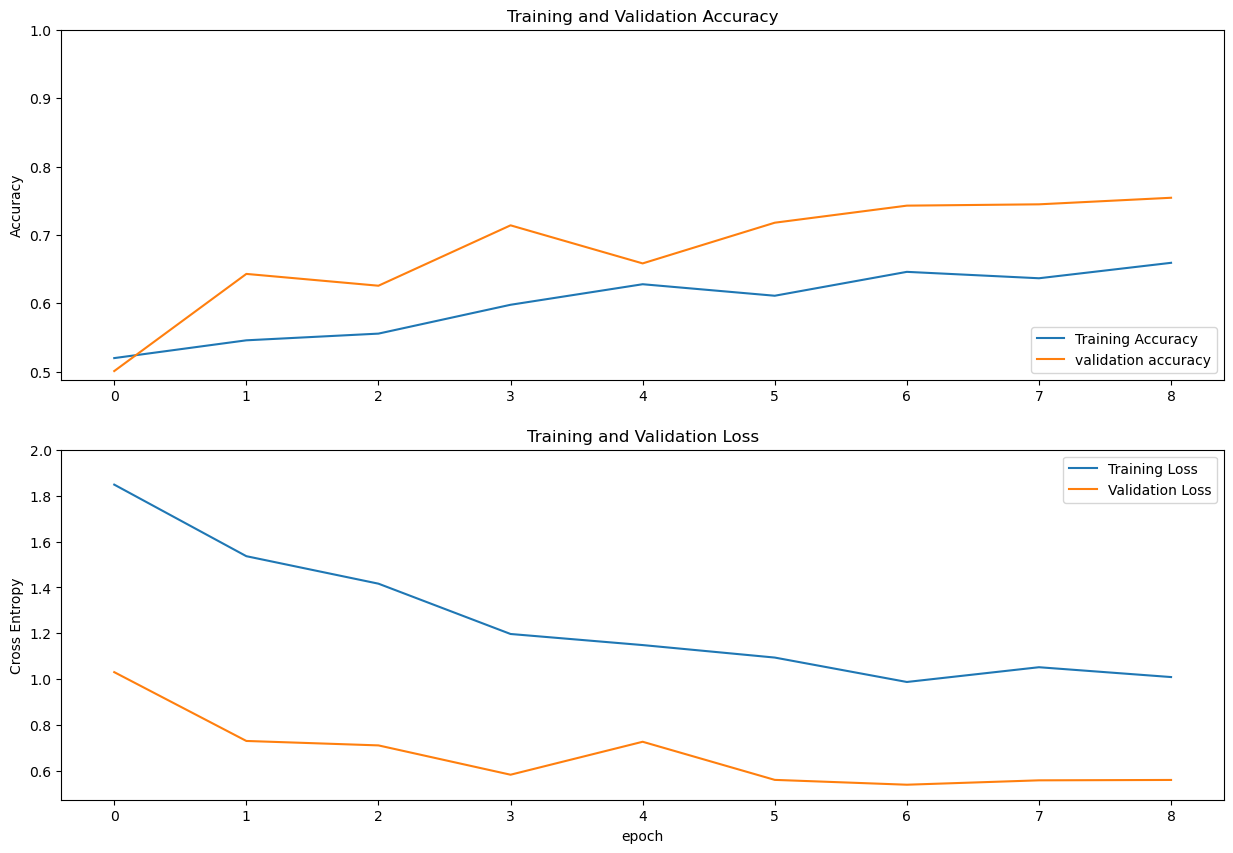

In [16]:
acc=  history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(acc,label='Training Accuracy')
plt.plot(val_acc, label="validation accuracy")
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')


plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()),2])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In some cases, the validation metrics are clearly better than the training metrics, the main factor is because layers like *tf.keras.layers.BatchNormalization and tf.keras.layers.Dropout* affect accuracy during training. They are turned off when calculating validation loss.

In [17]:
#Load the best model during initial training
model.load_weights(ckpt_filename)

## Fine-Tuning
one way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

In [18]:
#Finetuning - Unfreeze the last layers of the model
base_model.trainable = True

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1/conv (Conv2D)            (None, None, None,   9408        ['zero_padding2d[0][0]']         
                                64)                                                           

Compile the models.As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [20]:
#compile model
model.compile(optimizer= Adam(learning_rate=base_learning_rate/10), loss= "binary_crossentropy", metrics = ['accuracy'])

# Callbacks
final_ckpt_filename= "/kaggle/working/dn121_class_weights_best_model.hdf5"
checkpoint = ModelCheckpoint(filepath=final_ckpt_filename, save_best_only=True, save_weights_only=True, verbose = 1)

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, mode='min', verbose = 1)

In [21]:
fine_tune_epochs = 20

# Fitting the model
history_unfreeze = model.fit(train_gen,
                    epochs= fine_tune_epochs,
                    validation_data=val_gen,
                    callbacks=[checkpoint, early_stop, lr_reduce],
                    class_weight = {0: class_weights[0], 1: class_weights[1]})

Epoch 1/20
147/147 [==============================] - ETA: 0s - loss: 0.3360 - accuracy: 0.9016
Epoch 1: val_loss improved from inf to 0.19623, saving model to /kaggle/working/dn121_class_weights_best_model.hdf5
147/147 [==============================] - 151s 924ms/step - loss: 0.3360 - accuracy: 0.9016 - val_loss: 0.1962 - val_accuracy: 0.9271 - lr: 1.0000e-05
Epoch 2/20
147/147 [==============================] - ETA: 0s - loss: 0.1368 - accuracy: 0.9476
Epoch 2: val_loss improved from 0.19623 to 0.16915, saving model to /kaggle/working/dn121_class_weights_best_model.hdf5
147/147 [==============================] - 133s 902ms/step - loss: 0.1368 - accuracy: 0.9476 - val_loss: 0.1692 - val_accuracy: 0.9328 - lr: 1.0000e-05
Epoch 3/20
147/147 [==============================] - ETA: 0s - loss: 0.1018 - accuracy: 0.9612
Epoch 3: val_loss improved from 0.16915 to 0.12130, saving model to /kaggle/working/dn121_class_weights_best_model.hdf5
147/147 [==============================] - 132s 899m

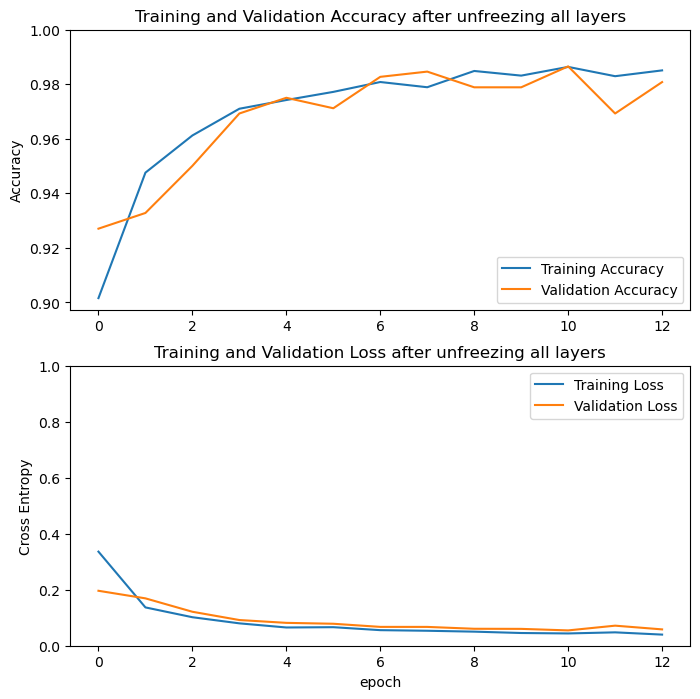

In [22]:
acc = history_unfreeze.history['accuracy']
val_acc = history_unfreeze.history['val_accuracy']

loss = history_unfreeze.history['loss']
val_loss = history_unfreeze.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy after unfreezing all layers')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss after unfreezing all layers')
plt.xlabel('epoch')
plt.show()

In [23]:
#Load the best model
model.load_weights(final_ckpt_filename)

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1/conv (Conv2D)            (None, None, None,   9408        ['zero_padding2d[0][0]']         
                                64)                                                           

In [25]:
#Evaluate on the test data
test_loss, test_score = model.evaluate(test_gen)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

20/20 [==============================] - 12s 595ms/step - loss: 0.1862 - accuracy: 0.9311
Loss on test set:  0.1861773133277893
Accuracy on test set:  0.9310897588729858


The below function is used to pre-process the images in test data and evaluate the model on the test set. It does the following:

Resize the images based on pre-trained model
Normalize the images on the pre-trained dataset

In [26]:
def fn_preprocess_images(data_directory, image_size):
    normal_dir = os.path.join(data_directory, 'NORMAL') 
    pneumonia_dir = os.path.join(data_directory, 'PNEUMONIA') 

     # Get the list of all the images
    normal_cases = glob(normal_dir + '/*.jpeg') 
    pneumonia_cases = glob(pneumonia_dir + '/*.jpeg')

    #Store all images and labels
    image_data_list = []
    labels = []

    for img_path in normal_cases:
        img = tf.keras.utils.load_img(img_path, target_size=(image_size, image_size))
        x = tf.keras.utils.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        #print('Input image shape:', x.shape)
        image_data_list.append(x)
        labels.append(0)

    for img_path in pneumonia_cases:
        img = tf.keras.utils.load_img(img_path, target_size=(image_size, image_size))
        x = tf.keras.utils.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        #print('Input image shape:', x.shape)
        image_data_list.append(x)
        labels.append(1)
  #Convert the images to tensor shape (n_images, h, w, channel)
    img_data = np.array(image_data_list)
    img_data=np.rollaxis(img_data,1,0)
    img_data=img_data[0]
    print("Final data shape: "+str(img_data.shape))

    #convert label list to numpy array
    labels = np.array(labels)

    return img_data,labels

In [27]:
test_data, test_labels  = fn_preprocess_images(test_dir_path, image_size = 224)


Final data shape: (624, 224, 224, 3)


In [28]:
#Predict on test data
preds = model.predict(test_data)

20/20 [==============================] - 4s 91ms/step


In [29]:
# Classification report 
from sklearn.metrics import accuracy_score,classification_report, roc_curve, confusion_matrix

acc = accuracy_score(test_labels, np.round(preds))*100
print("Test data accuracy : "+str(acc))
print("Classification report")
print(classification_report(test_labels,np.round(preds)))

Test data accuracy : 93.10897435897436
Classification report
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       234
           1       0.95      0.94      0.94       390

    accuracy                           0.93       624
   macro avg       0.93      0.93      0.93       624
weighted avg       0.93      0.93      0.93       624



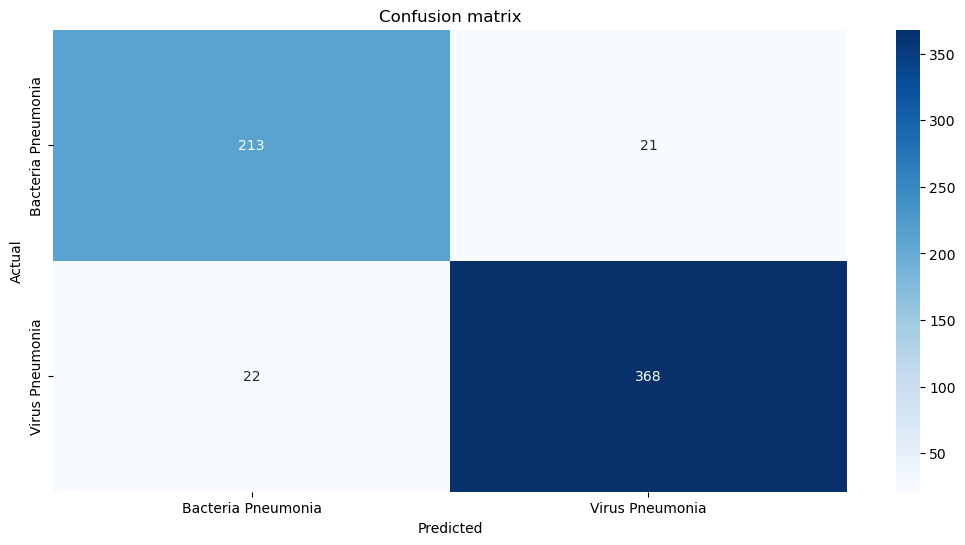

In [30]:
#Plot the confusion matrix
conf_matrix = confusion_matrix(test_labels, np.round(preds))
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=['Bacteria Pneumonia', 'Virus Pneumonia'], 
            yticklabels=['Bacteria Pneumonia', 'Virus Pneumonia'],
            cmap="Blues",
            fmt='g')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.show()

## ROC Curve


In [31]:
from sklearn.metrics import roc_curve, auc
y_preds = preds.ravel()
model_fpr, model_tpr, model_threshold = roc_curve(test_labels, y_preds)
model_auc = auc(model_fpr, model_tpr)

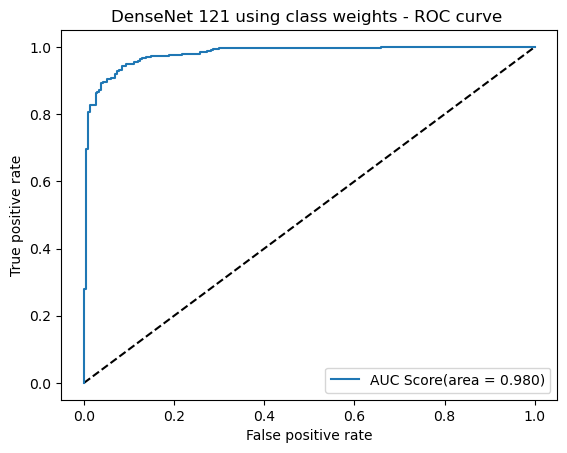

In [32]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(model_fpr, model_tpr, label='AUC Score(area = {:.3f})'.format(model_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('DenseNet 121 using class weights - ROC curve ')
plt.legend(loc='best')
plt.show()

## Model Interpretability using Grad-CAM
As a deep learning practitioner, one is responsible to ensure the model is performing correctly. One way you can do that is to debug your model and visually validate that it is “looking” and “activating” at the correct locations in an image.

To help deep learning practitioners debug their networks, Selvaraju et al. published a novel paper entitled, Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization. This method is:

Easily implemented
Works with nearly any Convolutional Neural Network architecture
Can be used to visually debug where a network is looking in an image

*Gradient-weighted Class Activation Mapping (Grad-CAM)* works by (1) finding the final convolutional layer in the network and then (2) examining the gradient information flowing into that layer.

*The output of Grad-CAM is a heatmap visualization for a given class label (either the top, predicted label or an arbitrary label we select for debugging). We can use this heatmap to visually verify where in the image the CNN is looking.*